In [ ]:
# Final version of model-based and data driven approach code
# Turki Haj Mohamad 9/13/2020

feature shape (839, 24)
target shape (839, 1)
speed shape: (839, 1)
[0 1 2]
24
[[89  3  0]
 [ 0 99  0]
 [ 0  1 85]]
0.9855595667870036


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Glyph 9 missing from current font.
Glyph 9 missing from current font.


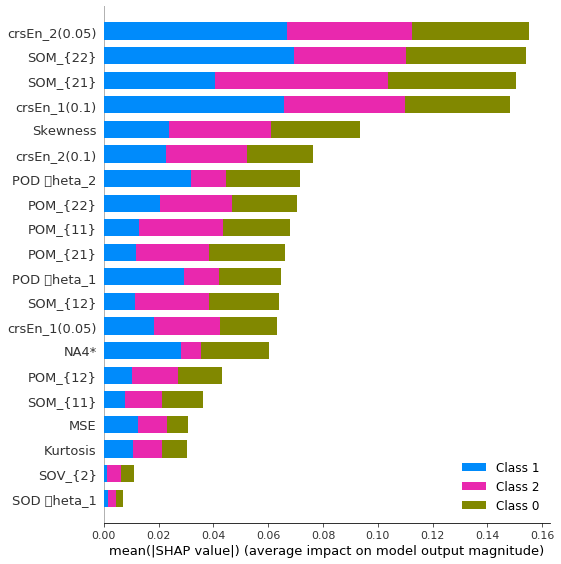

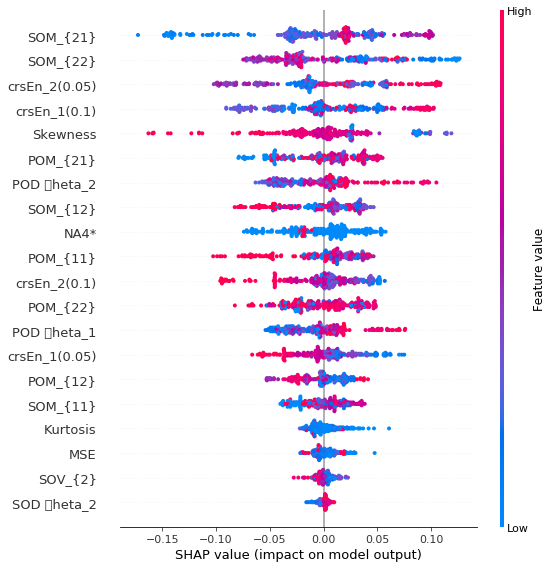

shape of shap values: (3, 277, 24)
shape of shap values: (num_class,num_samples,num_feat)
(277, 24)
(24,)
[0.00160453 0.0017709  0.00182699 0.00228138 0.00238878 0.00368287
 0.01009864 0.01021866 0.01212564 0.01444219 0.02004733 0.02108631
 0.02136523 0.02153182 0.02201221 0.02270774 0.02345894 0.02389418
 0.02539676 0.03111479 0.04946737 0.05013367 0.05138833 0.05169844]
         col_name  feature_importance_vals
21  crsEn_2(0.05)                 0.051698
11       SOM_{22}                 0.051388
10       SOM_{21}                 0.050134
22   crsEn_1(0.1)                 0.049467
17       Skewness                 0.031115
23   crsEn_2(0.1)                 0.025397
3    POD \theta_2                 0.023894
15       POM_{22}                 0.023459
12       POM_{11}                 0.022708
14       POM_{21}                 0.022012
2    POD \theta_1                 0.021532
9        SOM_{12}                 0.021365
20  crsEn_1(0.05)                 0.021086
19           NA4*      

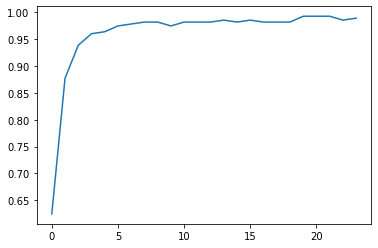

In [4]:
# import libraries
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import shap
import pandas as pd




# data loading

# insert filename
filename = 'Data_t2_v2_20505_32feat_839ex.mat'

# select wanted condition
# cond2study =1 # 

# random state of random forrest
nn_ =50

# slect numbr of features (should be updated to a feature set)
feat_set = range(24)

# Loading all the data as data dictionary (featureset target & speed)
input_mat = scipy.io.loadmat(filename)

# print(input_mat.keys())


# select input, speed, target from the data dictionary
Feat_mat = input_mat['Feat_mat'][:,feat_set]
Target_vec = input_mat['Target_vec']
speed_vec = input_mat['speed_vec']

# Feat_mat = Feat_mat[:,0:24]
print('feature shape',Feat_mat.shape)
print('target shape',Target_vec.shape)
print('speed shape:', speed_vec.shape)

# fix dimensionality (shape)
Target_vec = Target_vec.reshape((Target_vec.shape[0],))
print(np.unique(Target_vec))

    
# features names

names_DB = ['SOD \theta_1','SOD \theta_2','POD \theta_1','POD \theta_2','SOV_{1}','SOV_{2}','POV_{1}','POV_{2}','SOM_{11}','SOM_{12}','SOM_{21}','SOM_{22}','POM_{11}','POM_{12}','POM_{21}','POM_{22}']
names_MB = ['MSE','Skewness','Kurtosis','NA4*','crsEn_1(0.05)','crsEn_2(0.05)','crsEn_1(0.1)','crsEn_2(0.1)']            
names_hy = names_DB+names_MB


print(len(names_hy))  
    
# data is ready    
    
#___________________________________________Random Forrest Model_____________________________________________________

def model_gen(X_train,y_train,X_test,y_test,model,c_rf):
    
    model.fit(X_train, y_train)
    if c_rf ==1:
        print("Features sorted by their score:")
        print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names_hy), reverse=True))
    
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    print(accuracy_score(y_test,y_pred))
    if len(np.unique(y_train))==2:
        print(precision_score(y_test,y_pred))
        print(recall_score(y_test,y_pred))
    return model


# devide data

X_train, X_test, y_train, y_test = train_test_split(Feat_mat, Target_vec, test_size=0.33, random_state=42)
        
# rf = RandomForestClassifier(min_samples_split=10,max_depth=5)
model2study = RandomForestClassifier(random_state=nn_)             
c_rf = 0
rf = model_gen(X_train,y_train,X_test,y_test,model2study,c_rf)

# random forrest model is ready

#________________________________________________SHAP feature ranking___________________________________________________

def SHAP_plotfun(model,X_test,feat_names,class2show):
    fig = plt.figure()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=feat_names)
    plt.show()
    
    shap.summary_plot(shap_values[class2show], X_test,feature_names=feat_names)
    
    return shap_values
    # fig.savefig('summary_plot.png')

class2show = 0    
shap_values_hy = SHAP_plotfun(rf,X_test,names_hy,class2show)

print('shape of shap values:', np.array(shap_values_hy).shape)
print('shape of shap values:','(num_class,num_samples,num_feat)')


#___________________________________________________SHAP values_____________________________________________________

def SHAP_rankfun(shap_values,names_feat):
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(names_feat, np.mean(vals,axis=0))), columns=['col_name','feature_importance_vals'])
    # feature_importance = pd.DataFrame( vals.reshape(-1,2))#, columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    return feature_importance
        
    
vals= np.abs(shap_values_hy).mean(0)
# vals1= np.abs(np.array(shap_values)[0,:,:]).mean(0)
# vals2= np.abs(np.array(shap_values)[1,:,:]).mean(0)

print(np.abs(shap_values_hy).mean(0).shape)
print(np.mean(vals,axis=0).shape)
# print(np.sort(vals1))
# print(np.sort(vals2))
print(np.sort(np.mean(vals,axis=0)))


feature_importance_hy = SHAP_rankfun(shap_values_hy,names_hy)
print(feature_importance_hy)




#___________________________________________using ranked features______________________________________


def ranked_feat_plotter(model,y_test,feature_importance):
    feat_set = []
    accuracy_score_ =[]
    precision_score_ =[]
    recall_score_ =[]
    c=0
    for x in feature_importance.index:
        feat_set.append(x)
        rf = model
        rf.fit(X_train[:,feat_set], y_train)
        y_pred = rf.predict(X_test[:,feat_set])

        accuracy_score_.append(accuracy_score(y_test,y_pred))
        if len(np.unique(y_test))==2:
            precision_score_.append(precision_score(y_test,y_pred))
            recall_score_.append(recall_score(y_test,y_pred))
    
    print('acc:',accuracy_score_)
    if len(np.unique(y_test))==2:
        print('precision:',precision_score_)
        print('recall:',recall_score_)
    plt.figure()
    plt.plot(accuracy_score_)
    plt.show()
    
    return accuracy_score_
    
accuracy_score_hy = ranked_feat_plotter(rf,y_test,feature_importance_hy)    
    

Features sorted by their score:
[(0.0966, 'POD \theta_1'), (0.0878, 'SOD \theta_2'), (0.0835, 'POD \theta_2'), (0.0787, 'SOD \theta_1'), (0.0596, 'POV_{1}'), (0.059, 'POM_{12}'), (0.0545, 'POV_{2}'), (0.0523, 'SOV_{1}'), (0.0487, 'POM_{11}'), (0.0447, 'SOM_{21}'), (0.0446, 'SOM_{12}'), (0.0444, 'SOV_{2}'), (0.0403, 'POM_{21}'), (0.039, 'SOM_{22}'), (0.0383, 'SOM_{11}'), (0.0377, 'POM_{22}'), (0.0271, 'MSE'), (0.026, 'Skewness'), (0.0085, 'Kurtosis'), (0.0068, 'crsEn_2(0.1)'), (0.0063, 'crsEn_1(0.1)'), (0.0062, 'NA4*'), (0.005, 'crsEn_1(0.05)'), (0.0044, 'crsEn_2(0.05)')]
[[83  5  4]
 [ 1 98  0]
 [ 4  0 82]]
0.9494584837545126


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


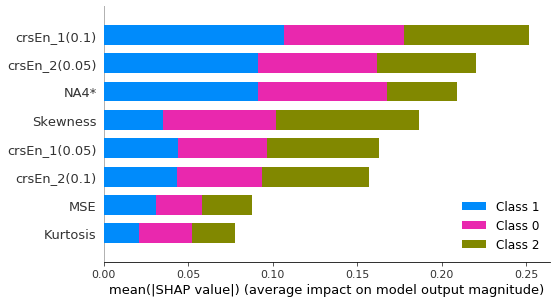

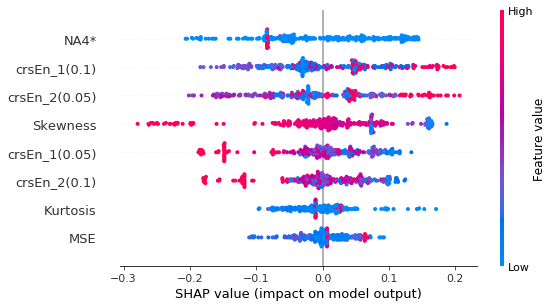

        col_name  feature_importance_vals
6   crsEn_1(0.1)                 0.083903
5  crsEn_2(0.05)                 0.073512
3           NA4*                 0.069759
1       Skewness                 0.062265
4  crsEn_1(0.05)                 0.054397
7   crsEn_2(0.1)                 0.052289
0            MSE                 0.029322
2       Kurtosis                 0.025856
acc: [0.5848375451263538, 0.6787003610108303, 0.9097472924187726, 0.9314079422382672, 0.9386281588447654, 0.9422382671480144, 0.9566787003610109, 0.9602888086642599]


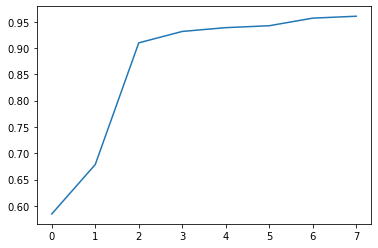

Features sorted by their score:
[(0.0966, 'POD \theta_1'), (0.0878, 'SOD \theta_2'), (0.0835, 'POD \theta_2'), (0.0787, 'SOD \theta_1'), (0.0596, 'POV_{1}'), (0.059, 'POM_{12}'), (0.0545, 'POV_{2}'), (0.0523, 'SOV_{1}'), (0.0487, 'POM_{11}'), (0.0447, 'SOM_{21}'), (0.0446, 'SOM_{12}'), (0.0444, 'SOV_{2}'), (0.0403, 'POM_{21}'), (0.039, 'SOM_{22}'), (0.0383, 'SOM_{11}'), (0.0377, 'POM_{22}'), (0.0271, 'MSE'), (0.026, 'Skewness'), (0.0085, 'Kurtosis'), (0.0068, 'crsEn_2(0.1)'), (0.0063, 'crsEn_1(0.1)'), (0.0062, 'NA4*'), (0.005, 'crsEn_1(0.05)'), (0.0044, 'crsEn_2(0.05)')]
[[90  2  0]
 [ 0 98  1]
 [ 1  1 84]]
0.9819494584837545


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Glyph 9 missing from current font.
Glyph 9 missing from current font.


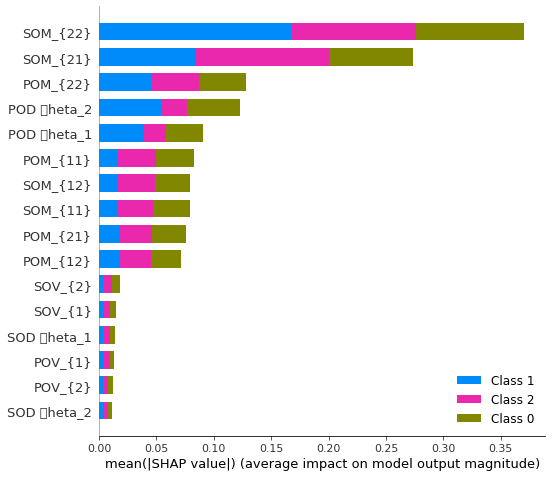

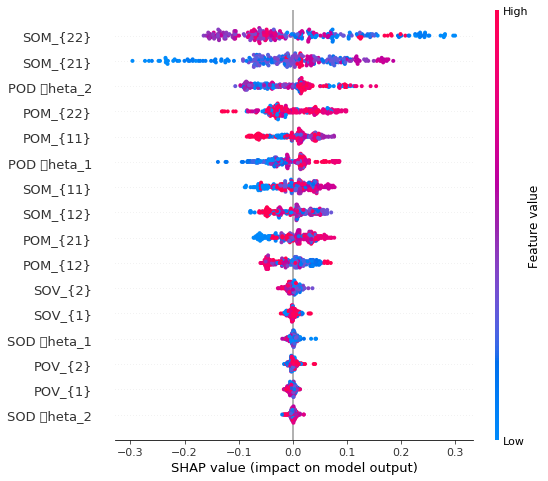

        col_name  feature_importance_vals
11      SOM_{22}                 0.123431
10      SOM_{21}                 0.091204
15      POM_{22}                 0.042652
3   POD \theta_2                 0.040825
2   POD \theta_1                 0.030287
12      POM_{11}                 0.027606
9       SOM_{12}                 0.026424
8       SOM_{11}                 0.026410
14      POM_{21}                 0.025217
13      POM_{12}                 0.023933
5        SOV_{2}                 0.006140
4        SOV_{1}                 0.005069
0   SOD \theta_1                 0.004631
6        POV_{1}                 0.004307
7        POV_{2}                 0.003990
1   SOD \theta_2                 0.003910
acc: [0.5667870036101083, 0.8736462093862816, 0.9422382671480144, 0.9747292418772563, 0.9891696750902527, 0.9819494584837545, 0.9819494584837545, 0.9819494584837545, 0.9819494584837545, 0.9819494584837545, 0.9855595667870036, 0.9819494584837545, 0.9855595667870036, 0.9783393501805054, 

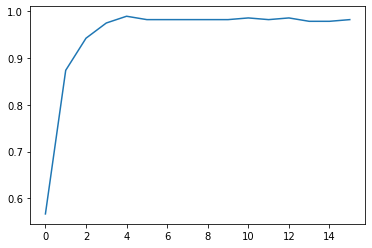

In [5]:
#_________________________________________Model Based features _____________________________________________

X_MB = Feat_mat[:,-8:].copy()
y_MB = Target_vec.copy()

X_train, X_test, y_train, y_test = train_test_split(X_MB, y_MB, test_size=0.33, random_state=42)

model2study = RandomForestClassifier(random_state=nn_)

c_rf=1
rf_MB = model_gen(X_train,y_train,X_test,y_test,model2study,c_rf)


class2show = 0    
shap_values_MB = SHAP_plotfun(rf_MB,X_test,names_MB,class2show)

feature_importance_MB = SHAP_rankfun(shap_values_MB,names_MB)
print(feature_importance_MB)
accuracy_score_MB =ranked_feat_plotter(rf_MB,y_test,feature_importance_MB)    


#_____________________________________ Data Based features______________________________________________

X_DB = Feat_mat[:,0:16].copy()
y_DB = Target_vec.copy()


X_train, X_test, y_train, y_test = train_test_split(X_DB, y_DB, test_size=0.33, random_state=42)

model2study = RandomForestClassifier(random_state=nn_)

c_rf=1
rf_DB = model_gen(X_train,y_train,X_test,y_test,model2study,c_rf)


class2show = 0    
shap_values_DB = SHAP_plotfun(rf_DB,X_test,names_DB,class2show)

feature_importance_DB = SHAP_rankfun(shap_values_DB,names_DB)
print(feature_importance_DB)
accuracy_score_DB =ranked_feat_plotter(rf_DB,y_test,feature_importance_DB)    



[<matplotlib.lines.Line2D at 0xca1e518>]

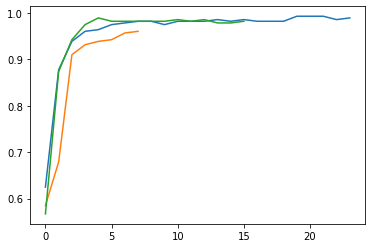

In [6]:
plt.figure()
plt.plot(accuracy_score_hy)
plt.plot(accuracy_score_MB)
plt.plot(accuracy_score_DB)


In [10]:

max(accuracy_score_MB)

0.9602888086642599